# MODIS Leaf Area Index - Thomas Fire

In [82]:
import json
import os
import pathlib

import earthpy as et
import geopandas as gpd
import pandas as pd
import requests
import xarray as xr
import rioxarray as rxr

In [45]:
%%bash
ls ~/earth-analytics

2021-capstone-repos
capstone-landslides-soilmoisture
data
landslide-detect
ndownloader.figshare.com
student-work
urban-stormwater-capture


In [46]:
# Set Working Directory
os.chdir(os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'earthpy-downloads'))

thomas_dir = 'thomas-fire-perimeter'
modis_dir = 'thomas-modis-lai'

for directory in (thomas_dir, modis_dir):
    if not os.path.exists(directory):
        print('{} does not exist. Creating...'.format(directory))
        os.makedirs(directory)

    print('{} exists.'.format(directory))
    
# Define the path to save the Thomas Fire Perimeter
thomas_path = os.path.join(thomas_dir, 'thomas-fire-perimeter')
modis_path_template = os.path.join(
    modis_dir,
    'MCD15A3H-thomas-{start_date}-{end_date}.json')
print(modis_path_template)

thomas-fire-perimeter exists.
thomas-modis-lai exists.
thomas-modis-lai/MCD15A3H-thomas-{start_date}-{end_date}.json


In [47]:
# Define the API query for the Thomas Fire Perimeter
thomas_url = (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/"
    "Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query"
    "?where="
        "incidentname%20%3D%20'THOMAS'"
        "%20AND%20%20(fireyear%20%3D%202017%20OR%20fireyear%20%3D%202018)"
        "%20%20AND%20state%20%3D%20'CA'"
    "&outFields=*"
    "&outSR=4326"
    "&f=json")

# Download Thomas Fire Perimeter if not cached
if not os.path.exists(thomas_path):
    # Download
    thomas_gdf = gpd.read_file(thomas_url)
    
    # Cache
    thomas_gdf.to_file(thomas_path)
    
# Load in cached Thomas Fire Perimeter
thomas_gdf = gpd.read_file(thomas_path)

# Pick the line with the maximum length
thomas_gdf = thomas_gdf[
    thomas_gdf['shape__Len']==max(thomas_gdf['shape__Len'])]

thomas_gdf

,OBJECTID,agency,comments,mapmethod,datecurren,uniquefire,fireyear,incidentna,pooownerun,perimeterd,...,poorespons,state,inciwebid,localincid,irwinid,incomplex,complexfir,shape__Are,shape__Len,geometry
1,110,C&L,Event Standard Perims,Unknown,1515369600000,2017-CAVNC-103156,2017,THOMAS,CAVNC,1515283200000,...,CAVNC,CA,5670,103156,943d8086-7df4-47c7-bb98-a358e962667e,N,None,1.681135e+09,540389.710077,"MULTIPOLYGON (((-119.05353 34.48781, -119.0532..."


<AxesSubplot:>

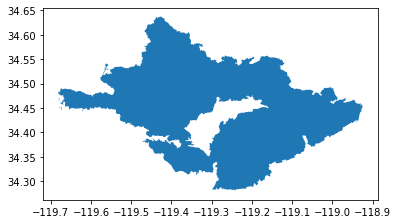

In [48]:
thomas_gdf.plot()

In [49]:
# Compute parameters for MODIS download
# Center coordinate
minlon, minlat, maxlon, maxlat = thomas_gdf.total_bounds
modis_lon = (minlon + maxlon) / 2
modis_lat = (minlat + maxlat) / 2

# Product
product = 'MCD15A3H'

# Start and end dates
start_date = '2014-01-01'
end_date = '2018-12-31'

# Radii
modis_crs = (
    '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 '
    '+units=m +no_defs +type=crs')
thomas_sinu_gdf = thomas_gdf.to_crs(modis_crs)
minx, miny, maxx, maxy = thomas_sinu_gdf.total_bounds
m_per_km = 1000
km_above_below = int((maxy - miny) / 2 / m_per_km)
km_left_right = int((maxx - minx) / 2 / m_per_km)

In [50]:
# Compute lists of start and end dates
start_dates = pd.date_range(start_date, end_date, freq='MS')
end_dates = pd.date_range(start_date, end_date, freq='M')
date_fmt = '%Y%j'

chunks = []
for sd, ed in zip(start_dates, end_dates):
    chunks.append({
        'start_date': sd.strftime(date_fmt),
        'end_date': ed.strftime(date_fmt)})
chunks

[{'start_date': '2014001', 'end_date': '2014031'},
 {'start_date': '2014032', 'end_date': '2014059'},
 {'start_date': '2014060', 'end_date': '2014090'},
 {'start_date': '2014091', 'end_date': '2014120'},
 {'start_date': '2014121', 'end_date': '2014151'},
 {'start_date': '2014152', 'end_date': '2014181'},
 {'start_date': '2014182', 'end_date': '2014212'},
 {'start_date': '2014213', 'end_date': '2014243'},
 {'start_date': '2014244', 'end_date': '2014273'},
 {'start_date': '2014274', 'end_date': '2014304'},
 {'start_date': '2014305', 'end_date': '2014334'},
 {'start_date': '2014335', 'end_date': '2014365'},
 {'start_date': '2015001', 'end_date': '2015031'},
 {'start_date': '2015032', 'end_date': '2015059'},
 {'start_date': '2015060', 'end_date': '2015090'},
 {'start_date': '2015091', 'end_date': '2015120'},
 {'start_date': '2015121', 'end_date': '2015151'},
 {'start_date': '2015152', 'end_date': '2015181'},
 {'start_date': '2015182', 'end_date': '2015212'},
 {'start_date': '2015213', 'end

In [51]:
# Add JSON File Name
for chunk in chunks:
    chunk['json_path'] =  modis_path_template.format(**chunk)
    
chunks

[{'start_date': '2014001',
  'end_date': '2014031',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014001-2014031.json'},
 {'start_date': '2014032',
  'end_date': '2014059',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014032-2014059.json'},
 {'start_date': '2014060',
  'end_date': '2014090',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014060-2014090.json'},
 {'start_date': '2014091',
  'end_date': '2014120',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014091-2014120.json'},
 {'start_date': '2014121',
  'end_date': '2014151',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014121-2014151.json'},
 {'start_date': '2014152',
  'end_date': '2014181',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014152-2014181.json'},
 {'start_date': '2014182',
  'end_date': '2014212',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014182-2014212.json'},
 {'start_date': '2014213',
  'end_date': '2014243',
  'json_path': 'thomas-modis-lai/MCD15A3H-thomas-2014213-2014243.json'},


In [55]:
# Add URLS
url_template = (
    'https://modis.ornl.gov/rst/api/v1/{product}/subset'
    '?latitude={latitude}'
    '&longitude={longitude}'
    '&product={product}'
    '&startDate=A{start_date}'
    '&endDate=A{end_date}'
    '&kmAboveBelow={km_above_below}'
    '&kmLeftRight={km_left_right}')

for i, chunk in enumerate(chunks):
    print('Running chunk {}'.format(i))
    chunk['url'] = url_template.format(
        latitude=modis_lat,
        longitude=modis_lon,
        product=product,
        start_date=chunk['start_date'],
        end_date=chunk['end_date'],
        km_above_below=km_above_below,
        km_left_right=km_left_right)
print(chunk)

Running chunk 0
Running chunk 1
Running chunk 2
Running chunk 3
Running chunk 4
Running chunk 5
Running chunk 6
Running chunk 7
Running chunk 8
Running chunk 9
Running chunk 10
Running chunk 11
Running chunk 12
Running chunk 13
Running chunk 14
Running chunk 15
Running chunk 16
Running chunk 17
Running chunk 18
Running chunk 19
Running chunk 20
Running chunk 21
Running chunk 22
Running chunk 23
Running chunk 24
Running chunk 25
Running chunk 26
Running chunk 27
Running chunk 28
Running chunk 29
Running chunk 30
Running chunk 31
Running chunk 32
Running chunk 33
Running chunk 34
Running chunk 35
Running chunk 36
Running chunk 37
Running chunk 38
Running chunk 39
Running chunk 40
Running chunk 41
Running chunk 42
Running chunk 43
Running chunk 44
Running chunk 45
Running chunk 46
Running chunk 47
Running chunk 48
Running chunk 49
Running chunk 50
Running chunk 51
Running chunk 52
Running chunk 53
Running chunk 54
Running chunk 55
Running chunk 56
Running chunk 57
Running chunk 58
Running

In [73]:
# Download MODIS files
json_file_contents = []
for chunk in chunks:
    if os.path.exists(chunk['json_path']):
        print('File {} already exists. Not downloading.'
              .format(chunk['json_path']))
    else:
        print('File {} does not exist. Downloading...'
              .format(chunk['json_path']))
        response = requests.get(chunk['url'])
        
        with open(chunk['json_path'], 'w') as json_file:
            json.dump(response.json(), json_file)
            
    with open(chunk['json_path'], 'r') as json_file:
        json_file_content = json.load(json_file)
        json_file_contents.append(json_file_content)
        print(json_file_content['xllcorner'])

json_file_contents[0]

File thomas-modis-lai/MCD15A3H-thomas-2014001-2014031.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014032-2014059.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014060-2014090.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014091-2014120.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014121-2014151.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014152-2014181.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014182-2014212.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014213-2014243.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014244-2014273.json already exists. Not downloading.
-10969855.20
File thomas-modis-lai/MCD15A3H-thomas-2014274-2014304.j

{'xllcorner': '-10969855.20',
 'yllcorner': '3813990.28',
 'cellsize': 463.312716528,
 'nrows': 77,
 'ncols': 137,
 'band': 'all',
 'latitude': 34.45867831513905,
 'longitude': -119.303403088672,
 'header': 'https://modisrest.ornl.gov/rst/api/v1/MCD15A3H/subset?latitude=34.45867831513905&longitude=-119.303403088672&product=MCD15A3H&startDate=A2014001&endDate=A2014031&kmAboveBelow=19&kmLeftRight=34',
 'subset': [{'modis_date': 'A2014001',
   'calendar_date': '2014-01-01',
   'band': 'FparExtra_QC',
   'tile': 'h08v05',
   'proc_date': '2021245181149',
   'data': [136,
    136,
    176,
    136,
    136,
    136,
    136,
    128,
    128,
    128,
    176,
    176,
    176,
    176,
    176,
    176,
    136,
    160,
    136,
    136,
    136,
    136,
    128,
    128,
    128,
    128,
    128,
    128,
    0,
    176,
    128,
    128,
    128,
    128,
    128,
    128,
    128,
    128,
    128,
    128,
    136,
    136,
    136,
    128,
    128,
    128,
    128,
    128,
    1

In [90]:
lai_das = []
for lai_json in json_file_contents:
    xll, yll = float(lai_json['xllcorner']), float(lai_json['yllcorner'])
    cellsize = lai_json['cellsize']
    nrows, ncols = lai_json['nrows'], lai_json['ncols']
    
    x_coords = [xll + cellsize*xi for xi in range(ncols)]
    y_coords = [yll + cellsize*yi for yi in range(nrows)]
    y_coords.reverse()
    
    for date_obs in lai_json['subset']:
        if date_obs['band']=='Lai_500m':
            data_grid = [np.array_split(date_obs['data'], nrows)]
            date = [pd.to_datetime(date_obs['calendar_date'])]
            lai_da = xr.DataArray(
                data_grid,
                coords={'x': x_coords, 'y': y_coords, 'date': date},
                dims=['date', 'y', 'x'])
            lai_das.append(lai_da)
            
xr.concat(lai_das, dim='date')

<xarray.DataArray (date: 458, y: 77, x: 137)>
array([[[  3,   3,   1, ...,   5,   5,   7],
        [  1,   1,   1, ...,   5,   6,   6],
        [  2,   3,   3, ...,   6,   7,   6],
        ...,
        [254, 254, 254, ...,   3,   3,   3],
        [254, 254, 254, ...,   3,   2,   2],
        [254, 254, 254, ...,   2,   2,   2]],

       [[  4,   1,   1, ...,   6,   6,   7],
        [  1,   1,   1, ...,   5,   6,   6],
        [  1,   1,   2, ...,   6,   7,   7],
        ...,
        [254, 254, 254, ...,   1,   2,   2],
        [254, 254, 254, ...,   2,   1,   1],
        [254, 254, 254, ...,   2,   1,   1]],

       [[  4,   1,   2, ...,   6,   6,   7],
        [  1,   1,   1, ...,   5,   6,   6],
        [  1,   2,   2, ...,   6,   7,   6],
        ...,
...
        ...,
        [254, 254, 254, ...,   5,   5,   5],
        [254, 254, 254, ...,   4,   4,   4],
        [254, 254, 254, ...,   5,   4,   5]],

       [[  6,   3,   3, ...,   7,   9,   9],
        [  1,   1,   1, ...,   7,   6,   7],
        [  2,   3,   3, ...,  10,  10,   8],
        ...,
        [254, 254, 254, ...,   5,   5,   5],
        [254, 254, 254, ...,   5,   5,   5],
        [254, 254, 254, ...,   6,   4,   4]],

       [[  6,   3,   3, ...,   6,   8,   8],
        [  3,   3,   3, ...,   8,   8,   7],
        [  3,   3,   3, ...,  10,   8,   8],
        ...,
        [254, 254, 254, ...,   4,   4,   4],
        [254, 254, 254, ...,   5,   4,   4],
        [254, 254, 254, ...,   5,   4,   4]]])
Coordinates:
  * x        (x) float64 -1.097e+07 -1.097e+07 ... -1.091e+07 -1.091e+07
  * y        (y) float64 3.849e+06 3.849e+06 3.848e+06 ... 3.814e+06 3.814e+06
  * date     (date) datetime64[ns] 2014-01-01 2014-01-05 ... 2018-12-31